# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models # type: ignore
import matplotlib.pyplot as plt

In [2]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for gpu in gpus:
        print(f"GPU Name: {gpu}")
else:
    print("No GPU detected. Running on CPU.")

GPUs detected: 1
GPU Name: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Settings

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# Read Data

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   '../../datasets/data2.5k',
   shuffle = True,
   image_size=  (IMAGE_SIZE, IMAGE_SIZE),
   batch_size = BATCH_SIZE
)

Found 2500 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['CBB', 'CBSD', 'CGM', 'CH', 'CMD']


In [6]:
len(dataset)

79

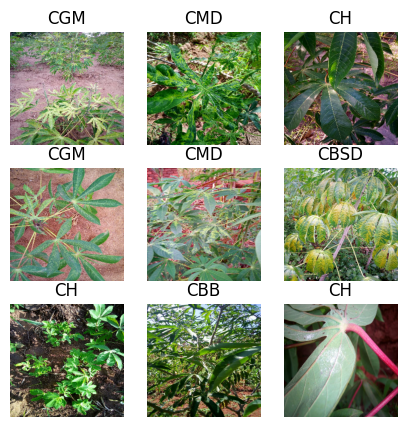

In [7]:
plt.figure(figsize=(5, 5))
for image_batch, label_batch in dataset.take(1):
   for i in range(9):
      ax =  plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

   ds_size = len(ds)

   if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

   train_size = int(train_split * ds_size)
   val_size = int(val_split * ds_size)

   train_ds = ds.take(train_size)
   val_ds = ds.skip(train_size).take(val_size)
   test_ds = ds.skip(train_size).skip(val_size)

   return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

63
7
9


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
   layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
   layers.RandomRotation(0.2),
])

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) 
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape) 

In [ ]:
model.summary()

In [ ]:
model.compile(
   optimizer='adam',
   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
   metrics=['accuracy'] 
)
validation_data = val_ds
validation_data

In [ ]:
history = model.fit(
   train_ds,
   epochs = EPOCHS,
   batch_size = BATCH_SIZE,
   verbose = 1,
   validation_data = val_ds
)

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
for images_batch, labels_batch in test_ds.take(1):
   first_image = images_batch[0].numpy().astype("uint8")
   first_label = labels_batch[0].numpy()

   print(f"First image: {class_names[first_label]}")
   plt.imshow(first_image)
   plt.show()

In [ ]:
# model.save('my_model.h5')

# from tensorflow.keras.models import load_model # type: ignore
# loaded_model = load_model('my_model.h5')


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Ensure test dataset is batched
# test_ds = test_ds.batch(BATCH_SIZE)

# # Get true labels and predictions
# true_labels = []
# predicted_labels = []

# for images, labels in test_ds:
#     predictions = model.predict(images)
#     predicted_labels.extend(np.argmax(predictions, axis=1))  # Get the predicted class
#     true_labels.extend(labels.numpy())  # Convert true labels to numpy

# # Convert to numpy arrays
# true_labels = np.array(true_labels)
# predicted_labels = np.array(predicted_labels)

# # Generate the confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# # Display the confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(n_classes))
# disp.plot(cmap='Blues', xticks_rotation='vertical')

# plt.title("Confusion Matrix")
# plt.show()
